In [ ]:
!pip install datashader
!apt-get install libgeos++ libproj-dev
!pip install geoviews

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgeos-c1' for regex 'libgeos+'
Note, selecting 'libgeos-c1v5' for regex 'libgeos+'
Note, selecting 'libgeos-dev' for regex 'libgeos+'
Note, selecting 'libgeos-doc' for regex 'libgeos+'
Note, selecting 'libgeos-ruby1.8' for regex 'libgeos+'
Note, selecting 'libgeos++-dev' for regex 'libgeos+'
Note, selecting 'libgeos-3.6.2' for regex 'libgeos+'
Note, selecting 'ruby-geos' instead of 'libgeos-ruby1.8'
libgeos++-dev is already the newest version (3.6.2-1build2).
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-c1v5 is already the newest version (3.6.2-1build2).
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-doc is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
ruby-geos is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import math
from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
userID = 'Jonas' #@param ["Jonas", "Klara", "Sara"]

if 'j' in userID[0].lower():
  working_path = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d '/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents'
    os.chdir(working_path) #Jonas connection
elif 's' in userID[0].lower():
  working_path = "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
    os.chdir(working_path) #Sara connection
else:
  working_path = "/content/drive/My Drive/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/project/DataLoaderForStudents"
    os.chdir(working_path) #Klara connection

In [ ]:
sys.path.append(f'{working_path}/MMM_DataLoaderForStudents/src')
from data_utils_conda import *
clear_output(wait=False)

In [ ]:
from modelClassC import *

In [ ]:
random.seed(123)
user_train, user_val, user_test = train, val, test = train_test_data_split(Random=True)
print("We train on users {}\n we validate on users {}\n and we test on users {}".format(user_train,user_val,user_test))

We train on users [0, 4, 1, 6, 10, 11, 8, 3]
 we validate on users [2]
 and we test on users [5, 7, 9]


### Load data set and adjust labels

In [ ]:
# get data
dataset = decompress_pickle(f'{working_path}/MMM_DataLoaderForStudents/Pickle/dataSet.pbz2')
dataset.rename(columns = {"label": "label2"})
labelMeaning = pd.read_csv(f'{working_path}/MMM_DataLoaderForStudents/UID-MMM-labels.csv').drop(columns='Unnamed: 0')[['stop','mode','howTravelled','purpose','mainActivity']]
labelMeaning.head()

,stop,mode,howTravelled,purpose,mainActivity
0,1,0,-100,14,Work
1,2,5,Foot,0,-100
2,1,0,-100,0,-100
3,2,5,Foot,0,-100
4,1,0,-100,14,Work


In [ ]:
# change index to 0/1
dataset.label2 = dataset.label2-1

In [ ]:
# image_ix:             ???
# segment_point_count:  length of minimum seq to infer on
# segment_ix:           step in trip
# segment_id:           where we are on grid ? (each sequence is split by cutoff_speed/time and labelled)
# tod:                  ???

In [ ]:
dataset["labelC"] = dataset.labelP.copy()
dataset.loc[dataset.labelC!=0,'labelC'] += len(dataset.labelM.unique())-1
dataset.loc[dataset.labelC==0,'labelC'] = dataset.loc[dataset.labelC==0,'labelM']
dataset.loc[dataset.labelC>17,'labelC'] = dataset.loc[dataset.labelC>17,'labelC'] - 1
#dataset.labelC[dataset.labelC == 0] = dataset.labelP[dataset.labelC == 0]+len(dataset.labelM.unique())
print(len(dataset.labelC.unique()),np.sort(dataset.labelC.unique()))
#for i in range(len(dataset)):
#  if dataset.labelC[i] == 0:
#    dataset.labelC[i] = dataset.labelP[i]+len(dataset.labelM.unique())

23 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [ ]:
tmphT = list(labelMeaning.howTravelled.unique())
tmpM = list(labelMeaning['mode'].unique())

In [ ]:
#labelMeaning.loc[labelMeaning['purpose_mode']!=0,'purpose_mode']
dataset['howTravelled'] = None
for i in range(len(tmphT)):
  dataset.loc[dataset['labelM']==tmpM[i],'howTravelled'] = tmphT[i]

In [ ]:
tmpmA = list(labelMeaning.mainActivity.unique())
tmpP = list(labelMeaning.purpose.unique())

In [ ]:
dataset['mainActivity'] = None
for i in range(len(tmpmA)):
  dataset.loc[dataset['labelP']==tmpP[i],'mainActivity'] = tmpmA[i]

#dataset.head()

In [ ]:
dataset['travelActivity'] = None

dataset.loc[dataset['howTravelled']==str(-100),'travelActivity'] = dataset.loc[dataset['howTravelled']==str(-100),'mainActivity']
dataset.loc[dataset['mainActivity']==str(-100),'travelActivity'] = dataset.loc[dataset['mainActivity']==str(-100),'howTravelled']

dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC,howTravelled,mainActivity,travelActivity
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1,11,-100,Eat Out,Eat Out
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1,4,Default,-100,Default
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1,4,Default,-100,Default
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606,4,Default,-100,Default
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606,4,Default,-100,Default


In [ ]:
# app. 178.000 data points without travel mode or purpose
#dataset.loc[dataset['travelActivity']==str(-100)]
# remove entries without travel mode or purpose
#dataset = dataset.loc[dataset['travelActivity']!=str(-100)].copy()
#dataset.labelC = dataset.labelC - 1

In [ ]:
#data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
#data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test if te != 4]).reset_index(drop=True)
# The following should be loaded after training phase. You can add the user 4 here, just fot technical limitations. It should be mentioned in the report.
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test+[4] if 4 in user_test else user_test]).reset_index(drop=True)

In [ ]:
#data_train = data_train[data_train['segment_ix'] >= 5]
#data_val = data_val[data_val['segment_ix'] >= 5]
#data_test = data_test[data_test['segment_ix'] >= 5]


#### Define class weights due to large class im-balance

In [ ]:
NUM_CLASSES = len(dataset.labelC.unique())
print(NUM_CLASSES)

23


In [ ]:
class_balance = [(dataset[label] == x).sum()/(dataset[label]).count() for x in range(NUM_CLASSES)]
label_meaning = dataset.sort_values(by=label).travelActivity.unique()
i=1
for x,y in zip(class_balance,label_meaning):
  print('{:2d}: {: .4%}, {}'.format(i,x,y))
  i += 1

 1:  12.1587%, -100
 2:  5.0961%, Air
 3:  3.7829%, Bicycle
 4:  9.3822%, Bus
 5:  7.1851%, Default
 6:  0.7443%, Foot
 7:  1.0678%, Light Rail
 8:  0.1998%, Other
 9:  0.0001%, Vehicle
10:  1.1123%, Accompany
11:  3.9262%, Change Mode
12:  0.7748%, Eat Out
13:  1.2792%, Education
14:  0.0067%, Entertainment
15:  0.2572%, Errands
16:  0.1307%, Exercise
17:  40.4558%, Home
18:  0.2901%, Medical
19:  0.0072%, Second Home
20:  0.3986%, Shopping
21:  0.5858%, Socialize
22:  11.1489%, Work
23:  0.0095%, Work Related


In [ ]:
NewPurpose = {'-100':[0],'Air':[1],'Bicycle':[2,5],'Public Transport':[3,6],'Other':[4,7,8],
              'Spare Time':[9,11,13,14,15,17,19,20],
              'Change Mode':[10],'Work':[12,21,22],'Home':[16,18]}

In [ ]:
#NewPurpose = {'Air':[0],'Bicycle':[1],'Public Transport':[2,5],'Other':[3,6,7],
#              'Foot':[4],'Spare Time':[8,10,12,13,14,16,18,19],
#              'Change Mode':[9],'Education':[11],'Home':[15,17],'Work':[20,21]}

In [ ]:
dataset['NewLabel'] = None
dataset['NewPurpose'] = None

i = 0
for key, value in NewPurpose.items():
  #print('{}\t{}'.format(key,value))
  dataset.loc[dataset['labelC'].isin(value),'NewPurpose'] = key
  dataset.loc[dataset['labelC'].isin(value),'NewLabel'] = i
  i += 1

dataset

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC,howTravelled,mainActivity,travelActivity,NewLabel,NewPurpose
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1,11,-100,Eat Out,Eat Out,5,Spare Time
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1,4,Default,-100,Default,4,Other
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1,4,Default,-100,Default,4,Other
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606,4,Default,-100,Default,4,Other
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606,4,Default,-100,Default,4,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468263,12,2018-07-09 16:30:49+00:00,117598,0,8,0,869.0,4.266650,-1.510229,0.004910,3,757,0,5,16,-100,Home,Home,8,Home
1468264,12,2018-07-09 16:31:30+00:00,117601,0,8,0,41.0,2.696760,-2.589798,0.065775,3,757,1,5,16,-100,Home,Home,8,Home
1468265,12,2018-07-09 16:32:11+00:00,117604,0,8,0,41.0,40.738431,0.446198,0.993620,3,757,2,5,16,-100,Home,Home,8,Home
1468266,12,2018-07-09 16:32:42+00:00,117606,0,8,0,31.0,34.794060,0.103120,1.122389,3,757,3,5,16,-100,Home,Home,8,Home


In [ ]:
NUM_CLASSES = len(dataset.NewLabel.unique())
NUM_CLASSES

9

In [ ]:
dataset['labelC_old'] = dataset.labelC.copy()
dataset['labelC'] = dataset.NewLabel.copy()

In [ ]:
#data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train if tr != 4]).reset_index(drop=True)
#data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val if va != 4]).reset_index(drop=True)
data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test if te != 4]).reset_index(drop=True)
# The following should be loaded after training phase. You can add the user 4 here, just fot technical limitations. It should be mentioned in the report.
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test+[4] if 4 in user_test else user_test]).reset_index(drop=True)

In [ ]:
data_test = data_test[data_test['segment_ix'] >= 5]


In [ ]:
print('test data labels: {}'.format(np.sort(data_test.labelC.unique())))

test data labels: [0 1 2 3 4 5 6 7 8]


In [ ]:
class_balance_test = [(data_test[label] == x).sum()/(data_test[label]).count() for x in range(NUM_CLASSES)]
label_meaning = data_test.sort_values(by=label).NewPurpose.unique()

In [ ]:
i=0
for x,y in zip(class_balance_test,label_meaning):
  print('{}: {:16s} {:>6.2%}'.format(i,y,x))
  i+=1

0: -100             22.61%
1: Air               4.81%
2: Bicycle           5.27%
3: Public Transport  4.88%
4: Other             6.57%
5: Spare Time        1.31%
6: Change Mode       4.54%
7: Work             10.06%
8: Home             39.95%


In [ ]:
data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train if tr != 4]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val if va != 4]).reset_index(drop=True)
data_train = data_train[data_train['segment_ix'] >= 5]
data_val = data_val[data_val['segment_ix'] >= 5]
class_balance_train = [(data_train[label] == x).sum()/(data_train[label]).count() for x in range(NUM_CLASSES)]
class_balance_val = [(data_val[label] == x).sum()/(data_val[label]).count() for x in range(NUM_CLASSES)]
i=0
for c,train,val in zip(label_meaning,class_balance_train,class_balance_val):
  print('{}: {:16s} {:>6.2%}\t{:>6.2%}'.format(i,c,train,val))
  i+=1

0: -100             13.68%	 0.00%
1: Air               0.72%	81.02%
2: Bicycle           2.41%	 1.99%
3: Public Transport 14.60%	 3.81%
4: Other             7.10%	 2.63%
5: Spare Time        6.99%	 2.58%
6: Change Mode       1.66%	 0.72%
7: Work             49.59%	 1.30%
8: Home              3.24%	 5.96%


In [ ]:
data_train.shape

(201758, 21)

In [ ]:
# due to class imbalance 
maxLabel = np.argmax(class_balance_test)
print(maxLabel)

maxWeight = 10
class_weights = [(data_test[label] == maxLabel).sum()/(data_test[label] == x).sum() for x in range(NUM_CLASSES)]
#class_weights = [(data_test[label]).count()/((data_test[label] == x).sum()*NUM_CLASSES) for x in range(NUM_CLASSES)]
#class_weights = [(data_train[label] == maxLabel).sum()/(data_train[label] == x).sum() for x in range(NUM_CLASSES)]
for i in range(len(class_weights)):
  if (math.isinf(class_weights[i])) or (class_weights[i]>maxWeight):
    class_weights[i] = maxWeight
#  elif :
#    maxWeight = class_weights[i]


class_weights = [maxWeight if class_weights[i]==-1 else class_weights[i] for i in range(len(class_weights))]
class_weights

8


[1.7668044091051456,
 8.307900612855718,
 7.578133125325013,
 8.178897151676722,
 6.082116026711185,
 10,
 8.805287009063445,
 3.9702356627162514,
 1.0]

In [ ]:
image_data = {}
#for user_id in user_train + user_val + user_test:
for user_id in user_test:
  image_data[user_id] = np.stack(decompress_pickle(working_path+f'/MMM_DataLoaderForStudents/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
  print(image_data[user_id].shape[0])

14112
22616
425710


In [ ]:
demo_dataset = ImageTensorDataset(data_test, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=2, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

X_img : torch.Size([2, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
X_seq : torch.Size([2, 6, 2])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
X_tod : torch.Size([2, 5])
tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
y : torch.Size([2])
tensor(0)


In [ ]:
test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [ ]:
model = CnnNet().cuda()
model.load_state_dict(torch.load(os.getcwd()+"/trained_model_labelC"))
model.eval()

CnnNet(
  (cnn_layer_1): Sequential(
    (0): Conv2d(11, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.45, inplace=False)
  )
  (cnn_layer_2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.45, inplace=False)
  )
  (rnn_layer): Sequential(
    (0): GRU(2, 4, num_layers=2, batch_first=True, bidirectional=True)
    (1): SelectItem()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Dropout(p=0.45, inplace=False)
  )
  (fc_lay

In [ ]:
sum(p.numel() for p in model.parameters())

39637

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).cuda())

In [ ]:
phases = {
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_seq, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
        X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
        X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
        y = y.float().cuda()#.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy())) 

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = list(NewPurpose.keys())))#list(map(str,range(9)))))

test
                  precision    recall  f1-score   support

            -100       0.82      0.07      0.12     98977
             Air       0.02      0.18      0.04     21049
         Bicycle       0.37      0.37      0.37     23076
Public Transport       0.24      0.41      0.30     21381
           Other       0.31      0.32      0.31     28752
      Spare Time       0.01      0.22      0.01      5732
     Change Mode       0.10      0.12      0.11     19860
            Work       0.01      0.00      0.00     44046
            Home       0.00      0.00      0.00    174873

        accuracy                           0.09    437746
       macro avg       0.21      0.19      0.14    437746
    weighted avg       0.24      0.09      0.09    437746



In [ ]:
confusion_matrix(phase['true'],phase['predicted'])

array([[ 6641, 39503,   116,   381,  2769, 42059,  7138,   320,    50],
       [   72,  3793,  4520, 10077,  1876,   396,   227,     0,    88],
       [    1,  1944,  8491, 10497,  1669,   398,    75,     0,     1],
       [    0,  5255,  4275,  8853,  2240,   292,   413,     0,    53],
       [  618,  8419,  1636,  3113,  9201,  4269,  1461,    29,     6],
       [    0,   848,   985,   590,  2019,  1260,    30,     0,     0],
       [  680,  3881,  2657,  2239,  6668,  1409,  2324,     0,     2],
       [   49,  1226,     0,   237,   177, 42326,    29,     2,     0],
       [   16, 87563,     4,  1250,  3224, 72007, 10809,     0,     0]])

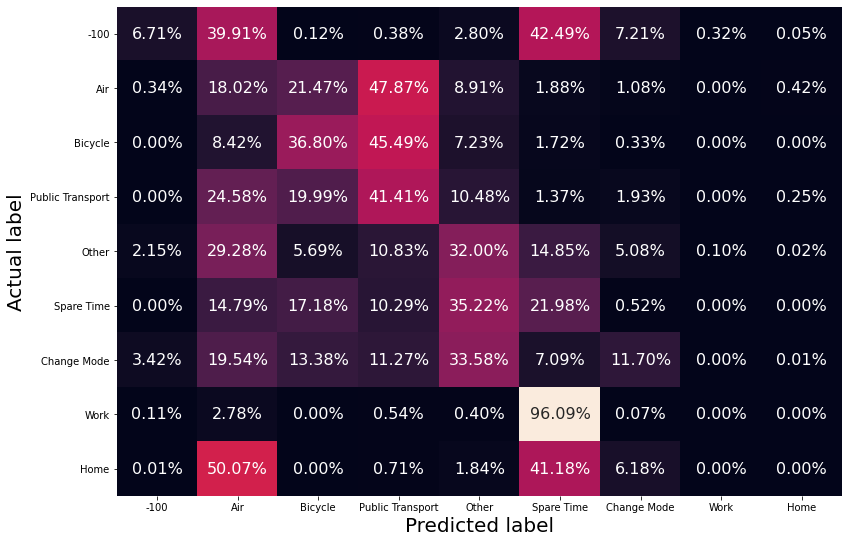

In [ ]:
array = confusion_matrix(phase['true'],phase['predicted'])
df_cm = pd.DataFrame(array, range(9), range(9))
plt.figure(figsize=(13,9))
#sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False) # counts
#sns.heatmap(df_cm/df_cm.sum(), annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False) # precision
sns.heatmap(df_cm.div(df_cm.sum(axis=1), axis=0), annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False,
            xticklabels=list(NewPurpose.keys()), yticklabels=list(NewPurpose.keys())) # recall
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('Actual label',fontsize=20)
#plt.title('Confusion matrix, with recall scores')
plt.show()